In [64]:
from matplotlib import pyplot as plt
from pygments.lexers.objective import objective
from sympy import OperationNotSupported
from tensorflow.python.ops.metrics_impl import accuracy


def visualize_results_performance(results):
    # Bar chart for classifier performance
    plt.figure(figsize=(10, 6))
    plt.bar(results.keys(), results.values(), color='skyblue')
    plt.xlabel('Classifier', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.title(f'Classifiers Accuracy for {file_name}', fontsize=16)
    plt.xticks(rotation=45)
    # plt.ylim(0, 100) # 0-100% accuracy

    # Calculate and plot the average accuracy
    log_loss = results.values()
    plt.axhline(y=log_loss, color='r', linestyle='--', label=f'Avg Accuracy: {log_loss:.4f}')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [65]:
from sklearn.utils.validation import check_array
from sklearn.preprocessing import LabelBinarizer
# 
# def adjust_predicted_probabilities(y_pred, n_classes):
#     """
#     Ensure predicted probabilities have probabilities for all classes.
#     """
#     n_samples, n_pred_classes = y_pred.shape
#     if n_pred_classes < n_classes:
#         adjusted_pred = np.zeros((n_samples, n_classes))
#         adjusted_pred[:, :n_pred_classes] = y_pred
#         return adjusted_pred
#     return y_pred

In [66]:
"""
Data analysis inspired by following article: https://www.kaggle.com/code/priyanshusethi/classification-model-comparison-diseases

In this article the author considered the target to be a 'Outcome variable' which is a binary variable.

However I am using the 'Disease' as the target variable which is a multi-class variable. I expect this to change 
(maybe significantly), the performance results.
"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from pathlib import Path

# Import functions from the analysis package
file_name = "Disease Symptoms and Patient Profile Dataset_exported"
dataset_path = Path(f"./kaggle/{file_name}.csv")
data = pd.read_csv(dataset_path)

# Analyze disease frequency
disease_counts = data['Disease'].value_counts()
print("Disease frequency distribution:")
print("Most common diseases:")
print(disease_counts.head())
print("\nRarest diseases:")
print(disease_counts.tail())
print(f"\nNumber of diseases with only one occurrence: {sum(disease_counts == 1)}")

# Filter out rare diseases (less than 2 occurrences)
min_instances = 10
frequent_diseases = disease_counts[disease_counts >= min_instances].index
data_filtered = data[data['Disease'].isin(frequent_diseases)]

print(f"\nOriginal number of samples: {len(data)}")
print(f"Number of samples after filtering rare diseases: {len(data_filtered)}")
print(f"Original number of diseases: {len(disease_counts)}")
print(f"Number of diseases after filtering: {len(frequent_diseases)}")


# features = data.iloc[:, 1:]
# target = data.iloc[:, 0]
# print(f"Features to be used for prediction:\n{features.head()}")
# print(f"Target variable:\n{target.head()}")
# 
# x_train,x_test,y_train,y_test = train_test_split(features, target, test_size=0.2, random_state=42)
# 
# oe = OrdinalEncoder(categories=[['No','Yes']])
# x_train_fever = oe.fit_transform(x_train["Fever"].array.reshape(-1, 1))
# x_test_fever = oe.transform(x_test["Fever"].array.reshape(-1, 1))
# 
# be = OrdinalEncoder(categories=[['No','Yes']])
# x_train_cough = be.fit_transform(x_train["Cough"].array.reshape(-1, 1))
# x_test_cough = be.transform(x_test["Cough"].array.reshape(-1, 1))
# 
# ce = OrdinalEncoder(categories=[['No','Yes']])
# x_train_fat = ce.fit_transform(x_train["Fatigue"].array.reshape(-1, 1))
# x_test_fat = ce.transform(x_test["Fatigue"].array.reshape(-1, 1))
# 
# de = OrdinalEncoder(categories=[['No','Yes']])
# x_train_breath = de.fit_transform(x_train["Difficulty Breathing"].array.reshape(-1, 1))
# x_test_breath = de.transform(x_test["Difficulty Breathing"].array.reshape(-1, 1))
# 
# fe = OrdinalEncoder(categories=[['Low','Normal',"High"]])
# x_train_blood = fe.fit_transform(x_train["Blood Pressure"].array.reshape(-1, 1))
# x_test_blood = fe.transform(x_test["Blood Pressure"].array.reshape(-1, 1))
# 
# ge = OrdinalEncoder(categories=[['Low','Normal',"High"]])
# x_train_chol = ge.fit_transform(x_train["Cholesterol Level"].array.reshape(-1, 1))
# x_test_chol = ge.transform(x_test["Cholesterol Level"].array.reshape(-1, 1))
# 
# gender_ohe = OneHotEncoder(drop='first')
# x_train_gender = gender_ohe.fit_transform(x_train['Gender'].array.reshape(-1, 1)).toarray() # The OneHotEncoder produces a sparse matrix, which may not concatenate directly with NumPy arrays (e.g., x_train_fever, x_train_cough). Sparse matrix stores only non-zero values to optimize space (CSR)
# x_test_gender = gender_ohe.transform(x_test['Gender'].array.reshape(-1, 1)).toarray()
# 
# outcome_ohe = OneHotEncoder(drop='first')
# x_train_outcome = outcome_ohe.fit_transform(x_train['Outcome Variable'].array.reshape(-1, 1)).toarray()
# x_test_outcome = outcome_ohe.fit_transform(x_test['Outcome Variable'].array.reshape(-1, 1)).toarray()
# 
# x_train_transformed = np.concatenate((x_train_fever,x_train_cough,x_train_fat,x_train_breath,x_train_blood,x_train_chol,x_train_gender, x_train_outcome),axis=1)
# 
# x_test_transformed = np.concatenate((x_test_fever,x_test_cough,x_test_fat,x_test_breath,x_test_blood,x_test_chol,x_test_gender, x_test_outcome),axis=1)
# 
# # Multi-class encoding for target variable, since it is a multi-class variable
# le = LabelEncoder()
# le.fit(list(y_train) + list(y_test))
# 
# y_train_encoded = le.transform(y_train)
# y_test_encoded = le.transform(y_test)
# 
# # Validation of classes throughout the encoding process
# # print(f"Classes in y_train_encoded: {np.unique(y_train_encoded)}")
# # print(f"Classes in y_test_encoded: {np.unique(y_test_encoded)}")
# # print(f"Classes in LabelEncoder: {len(le.classes_)}")


Disease frequency distribution:
Most common diseases:
Disease
Asthma          23
Stroke          16
Osteoporosis    14
Hypertension    10
Diabetes        10
Name: count, dtype: int64

Rarest diseases:
Disease
Autism Spectrum Disorder (ASD)    1
Hypoglycemia                      1
Fibromyalgia                      1
Eating Disorders (Anorexia,...    1
Williams Syndrome                 1
Name: count, dtype: int64

Number of diseases with only one occurrence: 61

Original number of samples: 349
Number of samples after filtering rare diseases: 83
Original number of diseases: 116
Number of diseases after filtering: 6


In [67]:

def adjust_predicted_probabilities(y_pred, n_classes):
    """
    Ensure predicted probabilities have probabilities for all classes.
    """
    n_samples, n_pred_classes = y_pred.shape
    if n_pred_classes < n_classes:
        adjusted_pred = np.zeros((n_samples, n_classes))
        adjusted_pred[:, :n_pred_classes] = y_pred
        return adjusted_pred
    return y_pred

def train_and_test_sklearn_classifier(clf, data):
    """
    
    Train and test a classifier on the given data.
    @param clf: classifier to be trained and tested
    @param data: dataset to be used for training and testing
    @return: log loss of the classifier
    """
    # create new copy of the data
    data = data.copy()
    
    features = data.iloc[:, 1:]
    target = data.iloc[:, 0]
    print(f"Features to be used for prediction:\n{features.head()}")
    print(f"Target variable:\n{target.head()}")
    
    x_train,x_test,y_train,y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    
    oe = OrdinalEncoder(categories=[['No','Yes']])
    x_train_fever = oe.fit_transform(x_train["Fever"].array.reshape(-1, 1))
    x_test_fever = oe.transform(x_test["Fever"].array.reshape(-1, 1))
    
    be = OrdinalEncoder(categories=[['No','Yes']])
    x_train_cough = be.fit_transform(x_train["Cough"].array.reshape(-1, 1))
    x_test_cough = be.transform(x_test["Cough"].array.reshape(-1, 1))
    
    ce = OrdinalEncoder(categories=[['No','Yes']])
    x_train_fat = ce.fit_transform(x_train["Fatigue"].array.reshape(-1, 1))
    x_test_fat = ce.transform(x_test["Fatigue"].array.reshape(-1, 1))
    
    de = OrdinalEncoder(categories=[['No','Yes']])
    x_train_breath = de.fit_transform(x_train["Difficulty Breathing"].array.reshape(-1, 1))
    x_test_breath = de.transform(x_test["Difficulty Breathing"].array.reshape(-1, 1))
    
    fe = OrdinalEncoder(categories=[['Low','Normal',"High"]])
    x_train_blood = fe.fit_transform(x_train["Blood Pressure"].array.reshape(-1, 1))
    x_test_blood = fe.transform(x_test["Blood Pressure"].array.reshape(-1, 1))
    
    ge = OrdinalEncoder(categories=[['Low','Normal',"High"]])
    x_train_chol = ge.fit_transform(x_train["Cholesterol Level"].array.reshape(-1, 1))
    x_test_chol = ge.transform(x_test["Cholesterol Level"].array.reshape(-1, 1))
    
    gender_ohe = OneHotEncoder(drop='first')
    x_train_gender = gender_ohe.fit_transform(x_train['Gender'].array.reshape(-1, 1)).toarray() # The OneHotEncoder produces a sparse matrix, which may not concatenate directly with NumPy arrays (e.g., x_train_fever, x_train_cough). Sparse matrix stores only non-zero values to optimize space (CSR)
    x_test_gender = gender_ohe.transform(x_test['Gender'].array.reshape(-1, 1)).toarray()
    
    outcome_ohe = OneHotEncoder(drop='first')
    x_train_outcome = outcome_ohe.fit_transform(x_train['Outcome Variable'].array.reshape(-1, 1)).toarray()
    x_test_outcome = outcome_ohe.fit_transform(x_test['Outcome Variable'].array.reshape(-1, 1)).toarray()
    
    x_train_transformed = np.concatenate((x_train_fever,x_train_cough,x_train_fat,x_train_breath,x_train_blood,x_train_chol,x_train_gender, x_train_outcome),axis=1)
    
    x_test_transformed = np.concatenate((x_test_fever,x_test_cough,x_test_fat,x_test_breath,x_test_blood,x_test_chol, x_test_gender, x_test_outcome),axis=1)
    
    # Multi-class encoding for target variable, since it is a multi-class variable
    le = LabelEncoder()
    le.fit(list(y_train) + list(y_test))
    
    y_train_transformed = le.transform(y_train)
    y_test_transformed = le.transform(y_test)
    
     # Train the model
    clf.fit(x_train_transformed, y_train_transformed)
    
    # Ensure pred contains probabilities
    if hasattr(clf, "predict_proba"):
        pred_proba = clf.predict_proba(x_test_transformed)
        pred_proba = adjust_predicted_probabilities(pred_proba, len(le.classes_))  # Adjust probabilities
    else:
        raise OperationNotSupported(f"Classifier {name} does not support probability predictions")
    
    loss = log_loss(
        y_true=y_test_transformed, 
        y_pred=pred_proba, 
        labels=np.arange(len(le.classes_))
    )
    
    accuracy = clf.score(x_test_transformed, y_test_transformed)
    return loss, accuracy

    

In [68]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss, classification_report
import xgboost as xgb

def train_and_test_xgboost(data):
    """
    Train and test an XGBoost classifier on the given data.
    @param data: dataset to be used for training and testing
    @return: log loss of the classifier
    """
    # create new copy of the data
    data = data.copy()
    
    # Initialize our label encoders
    le_disease = LabelEncoder()
    le_gender = LabelEncoder()
    
    # Encode the target variable (Disease)
    data['Disease_encoded'] = le_disease.fit_transform(data['Disease'])
    
    # Encode Gender
    data['Gender_encoded'] = le_gender.fit_transform(data['Gender'])
    
    # Convert Yes/No to 1/0 for symptom columns
    binary_columns = ['Fever', 'Cough', 'Fatigue', 'Difficulty Breathing']
    for col in binary_columns:
        data[col] = (data[col] == 'Yes').astype(int)
    
    # Convert Blood Pressure to numeric
    bp_map = {'Low': 0, 'Normal': 1, 'High': 2}
    data['Blood_Pressure_encoded'] = data['Blood Pressure'].map(bp_map)
    
    # Convert Cholesterol Level to numeric
    chol_map = {'Low': 0, 'Normal': 1, 'High': 2}
    data['Cholesterol_encoded'] = data['Cholesterol Level'].map(chol_map)
    
    # Prepare features and target
    features = ['Fever', 'Cough', 'Fatigue', 'Difficulty Breathing', 
               'Age', 'Gender_encoded', 'Blood_Pressure_encoded', 'Cholesterol_encoded']
    
    X = data[features]
    y = data['Disease_encoded']
    
    # Split the data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y
    )
    
    # Calculate class weights to handle imbalance
    class_weights = dict(zip(
        range(len(frequent_diseases)),
        len(y_train) / (len(frequent_diseases) * np.bincount(y_train))
    ))
    
    # Initialize XGBoost classifier
    n_classes = len(frequent_diseases)
    print(f"\nTraining XGBoost with {n_classes} diseases")
    
    xgb_model = xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=n_classes,
        learning_rate=0.1,
        max_depth=6,
        n_estimators=100,
        random_state=42,
        eval_metric=['mlogloss'],
        early_stopping_rounds=10,
        use_label_encoder=False,
        scale_pos_weight=1,  # We're handling class weights differently
        min_child_weight=1,  # Help with class imbalance
        subsample=0.8,       # Prevent overfitting
        colsample_bytree=0.8 # Prevent overfitting
    )
    
    # Train the model
    xgb_model.fit(
        X_train, 
        y_train,
        eval_set=[(X_test, y_test)],
        verbose=False,
        # Convert class weights to sample weights
        sample_weight=np.array([class_weights[y] for y in y_train])
    )
    
    # Get predictions
    y_pred_proba = xgb_model.predict_proba(X_test)
    y_pred = xgb_model.predict(X_test)
    
    # Calculate metrics
    loss = log_loss(y_test, y_pred_proba)
    accuracy = xgb_model.score(X_test, y_test)

    return loss, accuracy


Training and testing Naive Bayes:
Features to be used for prediction:
   Fever Cough Fatigue Difficulty Breathing  Age  Gender Blood Pressure  \
3    Yes   Yes      No                  Yes   25    Male         Normal   
4    Yes   Yes      No                  Yes   25    Male         Normal   
10   Yes    No      No                  Yes   28    Male           High   
14    No    No      No                   No   29    Male            Low   
20   Yes   Yes     Yes                  Yes   29  Female         Normal   

   Cholesterol Level Outcome Variable  
3             Normal         Positive  
4             Normal         Positive  
10            Normal         Positive  
14            Normal         Negative  
20            Normal         Positive  
Target variable:
3       Asthma
4       Asthma
10      Asthma
14    Diabetes
20      Stroke
Name: Disease, dtype: object

Model Performance:
Log Loss: 6.1122
Accuracy: 29.41%

Training and testing K-Neighbors:
Features to be used for pred

/Users/patrikholler/workspace/Multiple-Disease-Prediction-Bot/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:08:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model Performance:
Log Loss: 1.4489
Accuracy: 52.94%

Training and testing LightGBM:
Features to be used for prediction:
   Fever Cough Fatigue Difficulty Breathing  Age  Gender Blood Pressure  \
3    Yes   Yes      No                  Yes   25    Male         Normal   
4    Yes   Yes      No                  Yes   25    Male         Normal   
10   Yes    No      No                  Yes   28    Male           High   
14    No    No      No                   No   29    Male            Low   
20   Yes   Yes     Yes                  Yes   29  Female         Normal   

   Cholesterol Level Outcome Variable  
3             Normal         Positive  
4             Normal         Positive  
10            Normal         Positive  
14            Normal         Negative  
20            Normal         Positive  
Target variable:
3       Asthma
4       Asthma
10      Asthma
14    Diabetes
20      Stroke
Name: Disease, dtype: object
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the over

TypeError: unsupported format string passed to dict_values.__format__

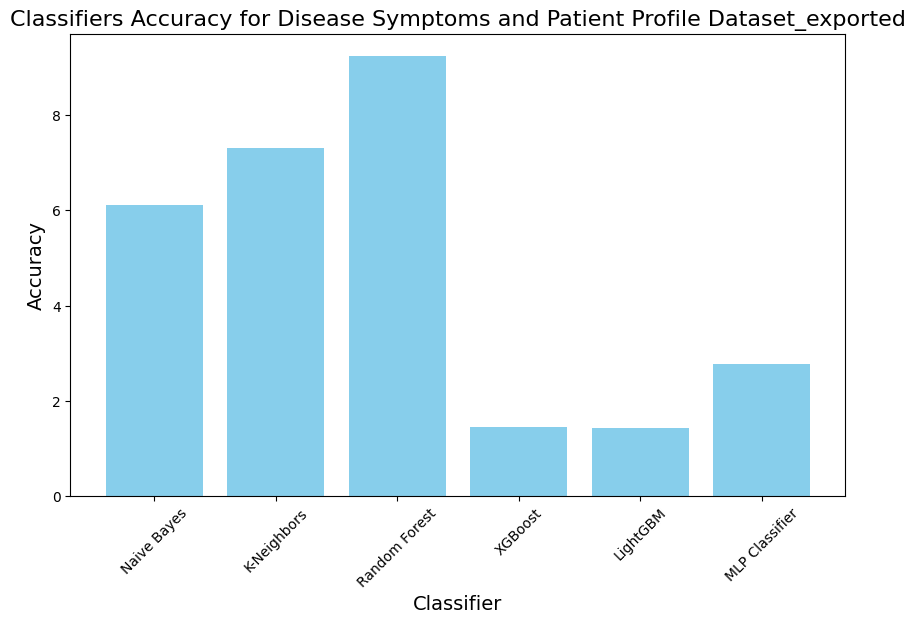

In [69]:
"""
ANALYSE dataset on different classifiers to assess performance when predicting the disease. Since the author is predicting multi-class variable needs to be used a `predict_proba()` method to calculate probability of each class (in other words it tells certainty of the prediction.

For binary classification, the `predict()` method is used.
"""

from sklearn.metrics import accuracy_score, log_loss
from sklearn import svm
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import KNeighborsClassifier

# Define classifiers
classifiers = {
    'Naive Bayes': GaussianNB(),
    'K-Neighbors': KNeighborsClassifier(n_neighbors=7), # tried 3, 5, 7, 10 -> 7 is the best
    'Random Forest': RandomForestClassifier(n_estimators=10, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=5, random_state=42),
    'LightGBM': LGBMClassifier(n_estimators=10, random_state=42), # TODO - resolve Warnings
    'MLP Classifier': MLPClassifier(random_state=42, max_iter=1000), # Multi-layer Perceptron
    # 'SVM': svm.SVC() # doesn't support predict_proba
}

results = dict()

# Train and test each classifier
for name, clf in classifiers.items():
    try:
        print(f"\nTraining and testing {name}:")
        
        if name == 'XGBoost':
            loss, accuracy = train_and_test_xgboost(data_filtered)
        else:
            loss, accuracy = train_and_test_sklearn_classifier(clf, data_filtered)
            
        print("\nModel Performance:")
        print(f"Log Loss: {loss:.4f}")
        print(f"Accuracy: {accuracy*100:.2f}%")      
        # Save the results
        results[name] = loss
    except Exception as e:
        print(f"Error: {e}")
        results[name] = 0

visualize_results_performance(results)


In [81]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss, classification_report
import xgboost as xgb

# Read the data and create DataFrame
data = pd.read_csv("./kaggle/Disease Symptoms and Patient Profile Dataset_exported.csv")

# Analyze disease frequency
disease_counts = data['Disease'].value_counts()
print("Disease frequency distribution:")
print("Most common diseases:")
print(disease_counts.head())
print("\nRarest diseases:")
print(disease_counts.tail())
print(f"\nNumber of diseases with only one occurrence: {sum(disease_counts == 1)}")

# Filter out rare diseases (less than 2 occurrences)
min_instances = 8
frequent_diseases = disease_counts[disease_counts >= min_instances].index
data_filtered = data[data['Disease'].isin(frequent_diseases)]

print(f"\nOriginal number of samples: {len(data)}")
print(f"Number of samples after filtering rare diseases: {len(data_filtered)}")
print(f"Original number of diseases: {len(disease_counts)}")
print(f"Number of diseases after filtering: {len(frequent_diseases)}")

# Initialize our label encoders
le_disease = LabelEncoder()
le_gender = LabelEncoder()

# Encode the target variable (Disease)
data_filtered['Disease_encoded'] = le_disease.fit_transform(data_filtered['Disease'])

# Encode Gender
data_filtered['Gender_encoded'] = le_gender.fit_transform(data_filtered['Gender'])

# Convert Yes/No to 1/0 for symptom columns
binary_columns = ['Fever', 'Cough', 'Fatigue', 'Difficulty Breathing']
for col in binary_columns:
    data_filtered[col] = (data_filtered[col] == 'Yes').astype(int)

# Convert Blood Pressure to numeric
bp_map = {'Low': 0, 'Normal': 1, 'High': 2}
data_filtered['Blood_Pressure_encoded'] = data_filtered['Blood Pressure'].map(bp_map)

# Convert Cholesterol Level to numeric
chol_map = {'Low': 0, 'Normal': 1, 'High': 2}
data_filtered['Cholesterol_encoded'] = data_filtered['Cholesterol Level'].map(chol_map)

# Prepare features and target
features = ['Fever', 'Cough', 'Fatigue', 'Difficulty Breathing', 
           'Age', 'Gender_encoded', 'Blood_Pressure_encoded', 'Cholesterol_encoded']

X = data_filtered[features]
y = data_filtered['Disease_encoded']

# Split the data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Calculate class weights to handle imbalance
class_weights = dict(zip(
    range(len(frequent_diseases)),
    len(y_train) / (len(frequent_diseases) * np.bincount(y_train))
))

# Initialize XGBoost classifier
n_classes = len(frequent_diseases)
print(f"\nTraining XGBoost with {n_classes} diseases")

xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=n_classes,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=5,
    random_state=42,
    eval_metric=['mlogloss'],
    early_stopping_rounds=10,
    use_label_encoder=False,
    scale_pos_weight=1,  # We're handling class weights differently
    min_child_weight=1,  # Help with class imbalance
    subsample=0.8,       # Prevent overfitting
    colsample_bytree=0.8 # Prevent overfitting
)

# Train the model
xgb_model.fit(
    X_train, 
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False,
    # Convert class weights to sample weights
    sample_weight=np.array([class_weights[y] for y in y_train])
)

# Get predictions
y_pred_proba = xgb_model.predict_proba(X_test)
y_pred = xgb_model.predict(X_test)

# Calculate metrics
loss = log_loss(y_test, y_pred_proba)
accuracy = xgb_model.score(X_test, y_test)

print("\nModel Performance:")
print(f"Log Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Feature importance analysis
importance = xgb_model.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': importance
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

print("\nTop 5 Most Important Features:")
print(feature_importance.head())

# Detailed classification report
print("\nClassification Report:")

# Get all classes in the dataset
all_classes = np.arange(len(le_disease.classes_))

# target_names = le_disease.classes_  # Original class names

# Only print the report for classes that appear in the test set
unique_test_classes = np.unique(y_test)
target_names = [le_disease.inverse_transform([i])[0] for i in unique_test_classes]
print(classification_report(y_test, y_pred, labels=unique_test_classes, target_names=target_names)) # labels=unique_test_classes

# Example predictions
print("\nExample Predictions:")
n_examples = 10
random_indices = np.random.choice(len(X_test), n_examples)
for idx in random_indices:
    true_disease = le_disease.inverse_transform([y_test.iloc[idx]])[0]
    pred_proba = y_pred_proba[idx]
    pred_disease = le_disease.inverse_transform([pred_proba.argmax()])[0]
    confidence = pred_proba.max()
    
    print(f"\nTrue Disease: {true_disease}")
    print(f"Predicted Disease: {pred_disease}")
    print(f"Confidence: {confidence:.4f}")

Disease frequency distribution:
Most common diseases:
Disease
Asthma          23
Stroke          16
Osteoporosis    14
Hypertension    10
Diabetes        10
Name: count, dtype: int64

Rarest diseases:
Disease
Autism Spectrum Disorder (ASD)    1
Hypoglycemia                      1
Fibromyalgia                      1
Eating Disorders (Anorexia,...    1
Williams Syndrome                 1
Name: count, dtype: int64

Number of diseases with only one occurrence: 61

Original number of samples: 349
Number of samples after filtering rare diseases: 107
Original number of diseases: 116
Number of diseases after filtering: 9

Training XGBoost with 9 diseases

Model Performance:
Log Loss: 1.9876
Accuracy: 0.4091

Top 5 Most Important Features:
                  Feature  Importance
3    Difficulty Breathing    0.270523
4                     Age    0.153682
2                 Fatigue    0.131032
6  Blood_Pressure_encoded    0.098096
5          Gender_encoded    0.097815

Classification Report:
       

/var/folders/yy/fgdl7tbx2cz5jbj2xw84dp3m0000gn/T/ipykernel_29127/638630647.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Disease_encoded'] = le_disease.fit_transform(data_filtered['Disease'])
/var/folders/yy/fgdl7tbx2cz5jbj2xw84dp3m0000gn/T/ipykernel_29127/638630647.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['Gender_encoded'] = le_gender.fit_transform(data_filtered['Gender'])
/var/folders/yy/fgdl7tbx2cz5jbj2xw84dp3m0000gn/T/ipykernel_29127/638630647.py:43: Setti

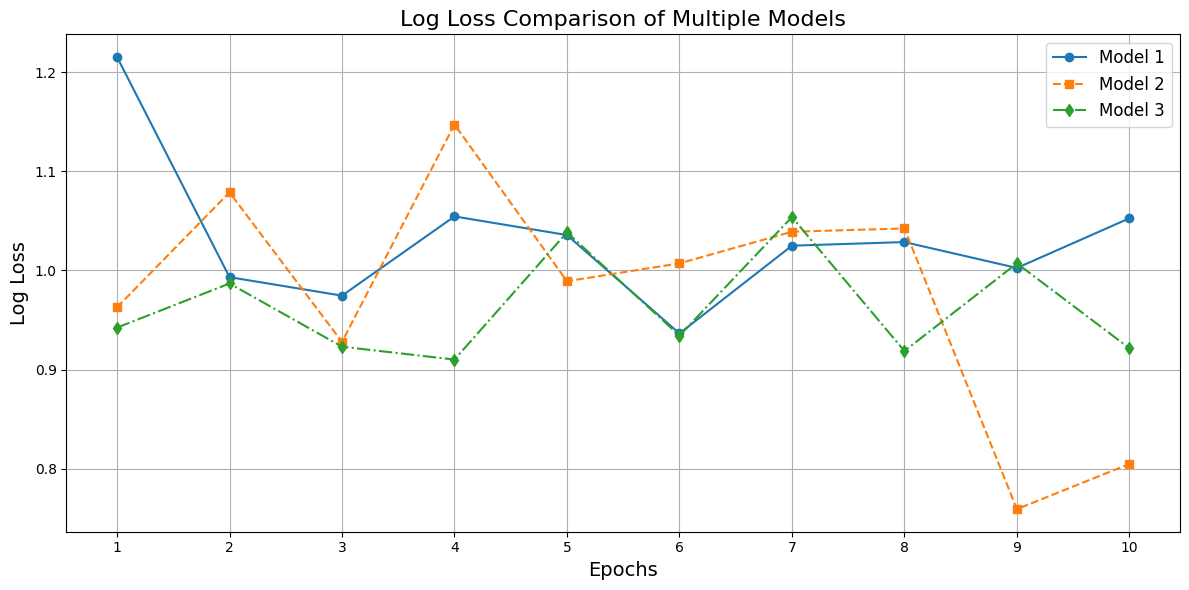

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
import numpy as np

# Example setup
epochs = list(range(1, 11))  # 10 epochs
true_labels = np.random.randint(0, 2, size=(100,))  # Random true labels for binary classification

# Simulating predicted probabilities for 3 models over epochs
model_1_preds = [np.clip(np.random.rand(100), 0.01, 0.99) for _ in epochs]
model_2_preds = [np.clip(np.random.rand(100), 0.01, 0.99) for _ in epochs]
model_3_preds = [np.clip(np.random.rand(100), 0.01, 0.99) for _ in epochs]

# Calculate log loss for each model
log_loss_model_1 = [log_loss(true_labels, preds) for preds in model_1_preds]
log_loss_model_2 = [log_loss(true_labels, preds) for preds in model_2_preds]
log_loss_model_3 = [log_loss(true_labels, preds) for preds in model_3_preds]

# Plotting the graph
plt.figure(figsize=(12, 6))
plt.plot(epochs, log_loss_model_1, label='Model 1', marker='o')
plt.plot(epochs, log_loss_model_2, label='Model 2', marker='s', linestyle='--')
plt.plot(epochs, log_loss_model_3, label='Model 3', marker='d', linestyle='-.')
plt.title('Log Loss Comparison of Multiple Models', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Log Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(epochs)
plt.tight_layout()
plt.show()